In [1]:
%load_ext autoreload
%autoreload 2


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import sys
import os
import time

from scipy.stats import t

#needed to import utils.py
sys.path.append('../') 

import utils
import utils_preprocessing
import utils_exec_models
import utils_exec_models_new

import numpy as np
import pandas as pd
#to view entire text of the comuns
pd.set_option('display.max_colwidth', None) 

import sklearn as sk

import tabulate

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML

from IPython.display import clear_output

import pickle


from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
import imblearn.under_sampling as resus
import imblearn.ensemble as resemb
import imblearn.combine as reshyb
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier

from itertools import combinations
from math import factorial



%matplotlib inline  

# Here:
 
## a. Define the repeated k-Fold CV strategy

## b. Create instances for the models having the best performance

## c. Then fit the models using CV and Training Data

In [26]:
%%time



CV_N_SPLITS = 5
CV_N_REPEATS = 20
RANDOM_STATE = 42

# CV strategy
cv = sk.model_selection.RepeatedStratifiedKFold(
    n_splits=CV_N_SPLITS, 
    n_repeats=CV_N_REPEATS, 
    random_state=RANDOM_STATE
)

# get train and tezt sets INCLUDING the Diagnosis_Delay feature
X_train, y_train, X_valid, y_valid = utils.get_train_and_validation_data(
    scaled=True,
    use_diagnosis_delay=True,
)


best_classifiers = utils_exec_models_new.get_best_model_instances()

grid_params = []
algorithms = []

for model_desc, scenario, model_instance in best_classifiers:
#     print(model_desc, model_instance)
    grid_params.append({'classifier': [model_instance]})
    algorithms.append(model_desc)

        
# Create a pipeline. Only used to set GridSearchCV. It will not be really used
pipeline = sk.pipeline.Pipeline(steps=[('classifier', GaussianNB() )])


grid = sk.model_selection.GridSearchCV(
    pipeline, 
    param_grid=grid_params, 
    scoring=utils_exec_models_new.get_default_scoring(), 
    cv=cv,
    n_jobs=9,
    verbose=1,
    refit='balanced_accuracy', 
)


# fit using only trainning set
grid.fit(X_train, y_train.values.ravel())
cv_results_trainning = grid.cv_results_



Fitting 100 folds for each of 12 candidates, totalling 1200 fits
CPU times: user 2.97 s, sys: 229 ms, total: 3.2 s
Wall time: 1min 38s


# Create dataFrame with the all "cv_results_" of all algorithm and scenarios

In [27]:
# trainning
df_results_trainning = pd.DataFrame(cv_results_trainning)
df_results_trainning.insert(0, 'Algorithm', algorithms)


display(df_results_trainning.head(3))


,Algorithm,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,params,split0_test_balanced_accuracy,split1_test_balanced_accuracy,split2_test_balanced_accuracy,...,split93_test_precision,split94_test_precision,split95_test_precision,split96_test_precision,split97_test_precision,split98_test_precision,split99_test_precision,mean_test_precision,std_test_precision,rank_test_precision
0,Decision Tree (EI),0.044070,0.009938,0.023018,0.004895,"BalancedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',\n max_depth=4,\n random_state=42),\n n_estimators=7, random_state=42, replacement=True,\n sampling_strategy='all', warm_start=True)","{'classifier': BalancedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42), n_estimators=7, random_state=42, replacement=True, sampling_strategy='all', warm_start=True)}",0.789790,0.780087,0.745327,...,0.428571,0.434211,0.333333,0.430556,0.491525,0.434783,0.337838,0.424894,0.044266,7
1,Decision Tree (SM),0.006048,0.001237,0.019024,0.004003,"DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42)","{'classifier': DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42)}",0.801495,0.770963,0.703267,...,0.333333,0.453333,0.301587,0.287037,0.394737,0.402439,0.324675,0.360799,0.045011,11
2,Neural Networks (EI),4.843130,1.111599,0.082644,0.018907,"BalancedBaggingClassifier(estimator=MLPClassifier(activation='tanh', alpha=0.1,\n hidden_layer_sizes=30,\n learning_rate='adaptive',\n learning_rate_init=0.7,\n max_iter=2000,\n random_state=42),\n n_estimators=101, random_state=42, replacement=True)","{'classifier': BalancedBaggingClassifier(estimator=MLPClassifier(activation='tanh', alpha=0.1, hidden_layer_sizes=30, learning_rate='adaptive', learning_rate_init=0.7, max_iter=2000, random_state=42), n_estimators=101, random_state=42, replacement=True)}",0.847116,0.837992,0.764821,...,0.423077,0.390805,0.402062,0.435897,0.430556,0.492754,0.350000,0.424233,0.041017,8


In [92]:

# best_classifiers = utils_exec_models_new.get_best_model_instances()

performances = []

for model_desc, scenario, model_instance in best_classifiers:
    model_instance.fit(X_train, y_train)
    y_pred = model_instance.predict(X_valid)
    y_pred_proba = model_instance.predict_proba(X_valid)[:,1]

    bal_acc, sens, spec, auc, acc, precision, f1 = utils_exec_models_new.get_performances_from_predictions(
        y_validation=y_valid, 
        y_pred=y_pred, 
        y_pred_proba=y_pred_proba,   
    )
    
    performances.append({
        'Model': model_desc,
        'bacc': bal_acc,
        'sens': sens,
        'spec': spec,
        'auc': auc,
    })
    
    
pd.DataFrame(performances)
    

,Model,bacc,sens,spec,auc
0,Decision Tree (EI),0.88,0.96,0.81,0.94
1,Decision Tree (SM),0.83,0.85,0.81,0.88
2,Neural Networks (EI),0.88,0.96,0.80,0.93
3,Neural Networks (SM),0.87,0.87,0.87,0.94
4,Random Forest (EI),0.87,0.96,0.79,0.93
5,Random Forest (SM),0.87,0.89,0.86,0.92
6,SVM (EI),0.87,0.94,0.81,0.93
7,SVM (SM),0.87,0.94,0.80,0.93
8,Naïve Bayes (EI),0.84,0.85,0.83,0.90
9,Naïve Bayes (SM),0.80,0.74,0.86,0.90


# Plot performance by each CV split CV test fold 

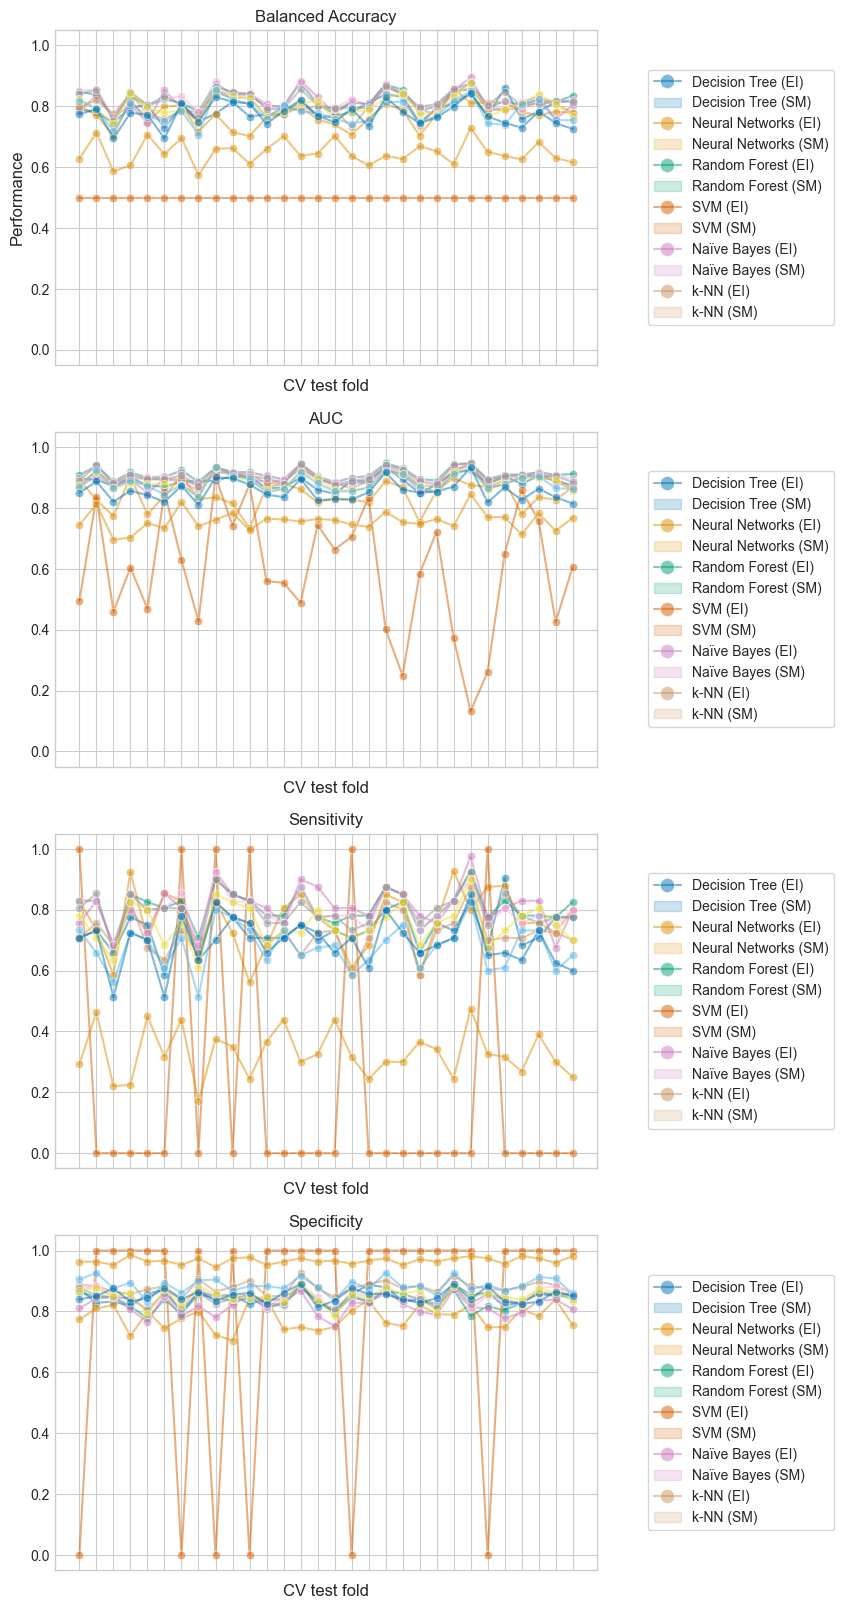

In [28]:
# results_df = df_results_trainning.copy()
results_df = df_results_trainning.copy()


# plot 30 examples of dependency between cv fold and AUC scores
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    4,1,
    figsize=(7,20), 
    sharex=False, 
    sharey=True
)

# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_balanced_accuracy")

g = sns.lineplot(
    ax=ax1,
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="colorblind",
    marker="o",
    alpha=0.5,
)
ax1.set_xlabel("CV test fold", size=12, labelpad=10)
ax1.set_ylabel("Performance", size=12)
ax1.tick_params(bottom=True, labelbottom=False)
ax1.set_title('Balanced Accuracy')

ax1.legend(results_df.Algorithm.values)
sns.move_legend(g, "center right", bbox_to_anchor=(1.45, 0.5), frameon=True, markerscale=1.7,)


# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_auc")
g = sns.lineplot(
    ax=ax2,
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="colorblind",
    marker="o",
    alpha=0.5,
)
ax2.set_xlabel("CV test fold", size=12, labelpad=10)
ax2.tick_params(bottom=True, labelbottom=False)
ax2.set_title('AUC')

ax2.legend(results_df.Algorithm.values)
sns.move_legend(g, "center right", bbox_to_anchor=(1.45, 0.5), frameon=True, markerscale=1.7,)


# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_sensitivity")
g = sns.lineplot(
    ax=ax3,
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="colorblind",
    marker="o",
    alpha=0.5,
)
ax3.set_xlabel("CV test fold", size=12, labelpad=10)
ax3.tick_params(bottom=True, labelbottom=False)
ax3.set_title('Sensitivity')

ax3.legend(results_df.Algorithm.values)
sns.move_legend(g, "center right", bbox_to_anchor=(1.45, 0.5), frameon=True, markerscale=1.7,)


# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_specificity")
g = sns.lineplot(
    ax=ax4,
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="colorblind",
    marker="o",
    alpha=0.5,
)
ax4.set_xlabel("CV test fold", size=12, labelpad=10)
ax4.tick_params(bottom=True, labelbottom=False)
ax4.set_title('Specificity')

ax4.legend(results_df.Algorithm.values)
sns.move_legend(g, "center right", bbox_to_anchor=(1.45, 0.5), frameon=True, markerscale=1.7,)


plt.show()

# # print correlation of Bal Acc scores across folds
# print(f"Correlation of models:")
# df_corr = pd.DataFrame(model_scores.transpose().corr())
# # display(df_corr)
# sns.heatmap(data=df_corr)

# Separate scores by type of metric (Bal.Acc., Sens., Spec., and AUC)
### Set default score to AUC

In [29]:

# create df of model scores ordered by performance
model_scores_balanced_accuracy = results_df.filter(regex=r"Algorithm|split\d*_test_balanced_accuracy")
model_scores_auc = results_df.filter(regex=r"Algorithm|split\d*_test_auc")
model_scores_sensitivity = results_df.filter(regex=r"Algorithm|split\d*_test_sensitivity")
model_scores_specificity = results_df.filter(regex=r"Algorithm|split\d*_test_specificity")


# model_scores = model_scores_balanced_accuracy.copy()
model_scores = model_scores_auc.copy()

# For each algorithm, compare if the performance in the Ensemble-Imbalance scenario was significantly superior than the Single-Model

In [85]:
# model_scores = model_scores_balanced_accuracy.copy()
model_scores = model_scores_auc.copy()

n_comparisons = factorial(len(model_scores)) / (
    factorial(2) * factorial(len(model_scores) - 2)
)

pairwise_t_test = []

for model_1, model_2 in combinations(range(len(model_scores)), 2):

    model_1_name = model_scores.iloc[model_1][0]
    model_2_name = model_scores.iloc[model_2][0]
    
    # print only the algorithms are the same
    if model_1_name.split('(')[0].strip() != model_2_name.split('(')[0].strip():
        continue
    
    
    model_1_scores = model_scores.iloc[model_1].values[1:]
    model_2_scores = model_scores.iloc[model_2].values[1:]

    differences = model_1_scores - model_2_scores

    # number of test sets
    n = differences.shape[0]  
    # degrees of freedom
    df = n - 1
    # get number of samples of the trainning and test sets
    n_train = len(list(cv.split(X_train, y_train))[0][0])
    n_test = len(list(cv.split(X_train, y_train))[0][1])

    # calculate significance using Bonferoni corrections
    t_stat, p_val = utils_exec_models_new.compute_corrected_ttest(differences, df, n_train, n_test)
    
    print(f"{model_1_name} vs. {model_2_name}:\n  Corrected t-value: {t_stat:.3f}\n  Corrected p-value: {p_val:.3f}")

    if p_val <= 0.05:
        first = 'first' if t_stat > 0 else 'second'
        second = 'first' if t_stat < 0 else 'second'
        print(f'  -> The corrected t-test concludes that the {first} model IS significantly better than the {second}')
    else:
        print(f'  -> The corrected t-test concludes that the {first} model >>IS NOT<< significantly better than the {second}')
    
    print()
    
    # Calculate the probalbility of first model being superior than the second
    t_post = t(
        df, 
        loc=np.mean(differences), 
        scale=utils_exec_models_new.corrected_std(differences, n_train, n_test)
    )

    better_prob = 1 - t_post.cdf(0)

    print(
        f"  -> Probability of {model_1_name} being more accurate than "
        f"{model_2_name}: {better_prob:.3f}"
    )
    print(
        f"  -> Probability of {model_2_name} being more accurate than "
        f"{model_1_name}: {1 - better_prob:.3f}"
    )    

    print()
    
    # check the probability of the models being practically equivalent
    rope_interval = [-0.01, 0.01]
    rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

    print(
        f"  -> Probability of {model_1_name} and {model_2_name} "
        f"being practically equivalent at ROPE={rope_interval[1]*100:.0f}%: {rope_prob*100:.1f}%"
    )
    print()



Decision Tree (EI) vs. Decision Tree (SM):
  Corrected t-value: 2.156
  Corrected p-value: 0.017
  -> The corrected t-test concludes that the first model IS significantly better than the second

  -> Probability of Decision Tree (EI) being more accurate than Decision Tree (SM): 0.983
  -> Probability of Decision Tree (SM) being more accurate than Decision Tree (EI): 0.017

  -> Probability of Decision Tree (EI) and Decision Tree (SM) being practically equivalent at ROPE=1%: 5.1%

Neural Networks (EI) vs. Neural Networks (SM):
  Corrected t-value: 2.961
  Corrected p-value: 0.002
  -> The corrected t-test concludes that the first model IS significantly better than the second

  -> Probability of Neural Networks (EI) being more accurate than Neural Networks (SM): 0.998
  -> Probability of Neural Networks (SM) being more accurate than Neural Networks (EI): 0.002

  -> Probability of Neural Networks (EI) and Neural Networks (SM) being practically equivalent at ROPE=1%: 0.1%

Random Forest 

# Inside the Ensemble-Imbalance scenario, verify what algorithm was superior with each other

In [82]:
# model_scores = model_scores_balanced_accuracy.copy()
model_scores = model_scores_auc.copy()

n_comparisons = factorial(len(model_scores)) / (
    factorial(2) * factorial(len(model_scores) - 2)
)

pairwise_t_test = []

for model_1, model_2 in combinations(range(len(model_scores)), 2):

    model_1_name = model_scores.iloc[model_1][0]
    model_2_name = model_scores.iloc[model_2][0]
    
    # print only if the algorithms are different and belong to Ensemble-Imbalance scenario
    different_algorithms = (model_1_name.split('(')[0].strip() != model_2_name.split('(')[0].strip())
    belong_to_ens_imb_scenario = ('(EI)' in model_1_name and '(EI)' in model_2_name)
    if not different_algorithms or not belong_to_ens_imb_scenario:
        continue
    
   
    model_1_scores = model_scores.iloc[model_1].values[1:]
    model_2_scores = model_scores.iloc[model_2].values[1:]

    differences = model_1_scores - model_2_scores

    # number of test sets
    n = differences.shape[0]  
    # degrees of freedom
    df = n - 1
    # get number of samples of the trainning and test sets
    n_train = len(list(cv.split(X_train, y_train))[0][0])
    n_test = len(list(cv.split(X_train, y_train))[0][1])

    # calculate significance using Bonferoni corrections
    t_stat, p_val = utils_exec_models_new.compute_corrected_ttest(differences, df, n_train, n_test)
    
    print(f"{model_1_name} vs. {model_2_name}:\n  Corrected t-value: {t_stat:.3f}\n  Corrected p-value: {p_val:.3f}")

    if p_val <= 0.05:
        first = 'first' if t_stat > 0 else 'second'
        second = 'first' if t_stat < 0 else 'second'
        print(f'  -> The corrected t-test concludes that the {first} model IS significantly better than the {second}')
    else:
        print(f'  -> The corrected t-test concludes that the {first} model >>IS NOT<< significantly better than the {second}')
    
    print()
    
    # Calculate the probalbility of first model being superior than the second
    t_post = t(
        df, 
        loc=np.mean(differences), 
        scale=utils_exec_models_new.corrected_std(differences, n_train, n_test)
    )

    better_prob = 1 - t_post.cdf(0)

    print(
        f"  -> Probability of {model_1_name} being more accurate than "
        f"{model_2_name}: {better_prob:.3f}"
    )
    print(
        f"  -> Probability of {model_2_name} being more accurate than "
        f"{model_1_name}: {1 - better_prob:.3f}"
    )    

    print()
    
    

    # check the probability of the models being practically equivalent
    rope_interval = [-0.01, 0.01]
    rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

    print(
        f"  -> Probability of {model_1_name} and {model_2_name} "
        f"being practically equivalent at ROPE={rope_interval[1]*100:.0f}%: {rope_prob*100:.1f}%"
    )
    print()


Decision Tree (EI) vs. Neural Networks (EI):
  Corrected t-value: -3.392
  Corrected p-value: 0.000
  -> The corrected t-test concludes that the second model IS significantly better than the first

  -> Probability of Decision Tree (EI) being more accurate than Neural Networks (EI): 0.000
  -> Probability of Neural Networks (EI) being more accurate than Decision Tree (EI): 1.000

  -> Probability of Decision Tree (EI) and Neural Networks (EI) being practically equivalent at ROPE=1%: 1.6%

Decision Tree (EI) vs. Random Forest (EI):
  Corrected t-value: -0.608
  Corrected p-value: 0.272
  -> The corrected t-test concludes that the second model >>IS NOT<< significantly better than the first

  -> Probability of Decision Tree (EI) being more accurate than Random Forest (EI): 0.272
  -> Probability of Random Forest (EI) being more accurate than Decision Tree (EI): 0.728

  -> Probability of Decision Tree (EI) and Random Forest (EI) being practically equivalent at ROPE=1%: 61.3%

Decision Tr

# Implement Bonferroni correction

## Example comparing the 2 first models

## Is the first model significantly better than the second?

### Alpha level at p-value = $0.05$

In [71]:
model_1_scores = model_scores.iloc[0].values  
model_2_scores = model_scores.iloc[1].values  

model_1_name = model_1_scores[0]
model_2_name = model_2_scores[0]

differences = model_1_scores[1:-1] - model_2_scores[1:-1]

n = differences.shape[0]  # number of test sets
df = n - 1
n_train = len(list(cv.split(X_train, y_train))[0][0])
n_test = len(list(cv.split(X_train, y_train))[0][1])

t_stat, p_val = utils_exec_models_new.compute_corrected_ttest(differences, df, n_train, n_test)
print(f"{model_1_name} vs. {model_2_name}:\n  Corrected t-value: {t_stat:.3f}\n  Corrected p-value: {p_val:.3f}")

if p_val <= 0.05:
    print('  -> The corrected t-test concludes that the first model IS significantly better than the second')
else:
    print('  -> The corrected t-test concludes that the first model IS NOT significantly better than the second')


Decision Tree (EI) vs. Decision Tree (SM):
  Corrected t-value: 2.137
  Corrected p-value: 0.018
  -> The corrected t-test concludes that the first model IS significantly better than the second


# Comparing two models: Bayesian approach
### In contrast with the previous Frequentist Approach, we can compute the probability that one model is better than the other.



In [72]:
# initialize random variable
t_post = t(
    df, 
    loc=np.mean(differences), 
    scale=utils_exec_models_new.corrected_std(differences, n_train, n_test)
)



better_prob = 1 - t_post.cdf(0)

print(
    f"Probability of {model_1_name} being more accurate than "
    f"{model_2_name}: {better_prob:.3f}"
)
print(
    f"Probability of {model_2_name} being more accurate than "
    f"{model_1_name}: {1 - better_prob:.3f}"
)

Probability of Decision Tree (EI) being more accurate than Decision Tree (SM): 0.982
Probability of Decision Tree (SM) being more accurate than Decision Tree (EI): 0.018


# Region of Practical Equivalence

### Sometimes we are interested in determining the probabilities that our models have an $equivalent$ performance

### A naive approach would be to define estimators as practically equivalent when they differ by less than 1% in their accuracy. But we could also define this practical equivalence taking into account the problem we are trying to solve

### In this example we are going to define the Region of Practical Equivalence (ROPE) to be $[-0.01, 0.01]$. That is, we will consider two models as practically equivalent if they differ by less than 1% in their performance.

Probability of Decision Tree (EI) and Decision Tree (SM) being practically equivalent at ROPE=1%: 0.054



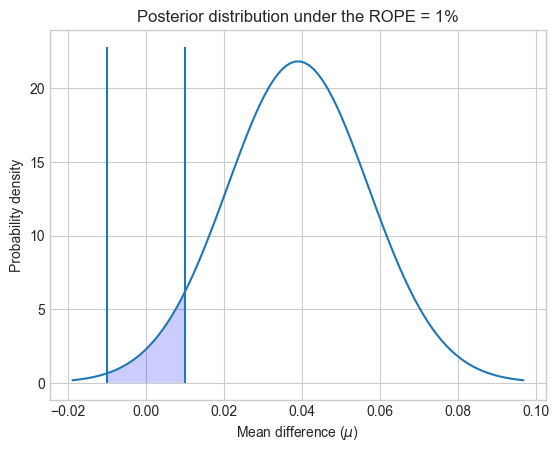

In [73]:
x = np.linspace(t_post.ppf(0.001), t_post.ppf(0.999), 100)

# test several percentages
for percentage in [0.01]: #, 0.02, 0.03, 0.04, 0.05, 0.10]:

    rope_interval = [-percentage, percentage]
    rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

    print(
        f"Probability of {model_1_name} and {model_2_name} "
        f"being practically equivalent at ROPE={rope_interval[1]*100:.0f}%: {rope_prob:.3f}"
    )
    print()
    
    x_rope = np.linspace(rope_interval[0], rope_interval[1], 100)

#     plt.figure(figsize=(5,5))
    plt.plot(x, t_post.pdf(x))
#     plt.xticks(np.arange(-0.04, 0.06, 0.01))
    plt.vlines([-percentage, percentage], ymin=0, ymax=(np.max(t_post.pdf(x)) + 1))
    plt.fill_between(x_rope, t_post.pdf(x_rope), 0, facecolor="blue", alpha=0.2)
    plt.ylabel("Probability density")
    plt.xlabel(r"Mean difference ($\mu$)")
    plt.title(f"Posterior distribution under the ROPE = {rope_interval[1]*100:.0f}%")
    plt.show()

# The Bayesian estimation approach also allows us to compute how uncertain we are about our estimation of the difference. 

### This can be calculated using credible intervals. For a given probability, they show the range of values that the estimated quantity, in our case the mean difference in performance, can take. 

### For example, a 50% credible interval $[x, y]$ tells us that there is a 50% probability that the true (mean) difference of performance between models is between x and y.

### Let’s determine the credible intervals of our data using 50%, 75% and 95%:

In [74]:
cred_intervals = []
intervals = [0.5, 0.75, 0.95]

for interval in intervals:
    cred_interval = list(t_post.interval(interval))
    cred_intervals.append([interval, cred_interval[0], cred_interval[1]])

cred_int_df = pd.DataFrame(
    cred_intervals, columns=["interval", "lower value", "upper value"]
).set_index("interval")
cred_int_df

,lower value,upper value
interval,,
0.50,0.026591,0.051256
0.75,0.017843,0.060003
0.95,0.002774,0.075073


As shown in the table, there is a 50% probability that the true mean difference between models will be between 0.000625 and 0.032204, 70% probability that it will be between -0.012697 and 0.044277, and 95% probability that it will be between -0.035319 and 0.066898.



# Pairwise comparison of all models: frequentist approach

### We could also be interested in comparing the performance of all our models evaluated with GridSearchCV. In this case we would be running our statistical test multiple times, which leads us to the multiple comparisons problem.

### There are many possible ways to tackle this problem, but a standard approach is to apply a $Bonferroni$ $correction$. Bonferroni can be computed by multiplying the p-value by the number of comparisons we are testing.

### Let’s compare the performance of the models using the corrected t-test:

#### SO, we observe that after correcting for multiple comparisons, which model that significantly differs from each other

In [75]:
models_scores = [
#     ['Balanced Accuracy', model_scores_balanced_accuracy.copy()],
#     ['Sensitivity', model_scores_sensitivity.copy()],
#     ['Specificity', model_scores_specificity.copy()],
    ['AUC', model_scores_auc.copy()],

]

# models_scores = [['AUC', model_scores]]


for algo_name, model_scores in models_scores:

    utils.print_string_with_separators(algo_name)
    
    # set Algorithm name as DF index
    model_scores.set_index('Algorithm', inplace=True)


    n_comparisons = factorial(len(model_scores)) / (
        factorial(2) * factorial(len(model_scores) - 2)
    )


    pairwise_t_test = []

    for model_i, model_k in combinations(range(len(model_scores)), 2):

        model_i_scores = model_scores.iloc[model_i].values
        model_k_scores = model_scores.iloc[model_k].values
        
        differences = model_i_scores - model_k_scores
        
        t_stat, p_val = utils_exec_models_new.compute_corrected_ttest(differences, df, n_train, n_test)

        p_val *= n_comparisons  # implement Bonferroni correction

        # Bonferroni can output p-values higher than 1
        p_val = 1 if p_val > 1 else p_val

        model_1 = model_scores.index[model_i]
        model_2 = model_scores.index[model_k]
        pairwise_t_test.append(
            [model_1, model_2, t_stat, p_val, (p_val<=0.05),
            (model_1.split('(')[0].strip() == model_2.split('(')[0].strip())
            ]
        )

    pairwise_comp_df = pd.DataFrame(
        pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val", "Is_Superior", "Same_Algorithm"]
    ).round(3)


#     print(pairwise_comp_df.loc[(pairwise_comp_df.Is_Superior)].to_markdown(index=False))
#     print()
    print(pairwise_comp_df.loc[(pairwise_comp_df.Same_Algorithm)].to_markdown(index=False))
    print()
#     # PRINT ALL 
#     print(pairwise_comp_df.to_markdown(index=False))
#     print()


---
AUC
---
| model_1              | model_2              |   t_stat |   p_val | Is_Superior   | Same_Algorithm   |
|:---------------------|:---------------------|---------:|--------:|:--------------|:-----------------|
| Decision Tree (EI)   | Decision Tree (SM)   |    2.156 |   1     | False         | True             |
| Neural Networks (EI) | Neural Networks (SM) |    2.961 |   0.127 | False         | True             |
| Random Forest (EI)   | Random Forest (SM)   |   -1.132 |   1     | False         | True             |
| SVM (EI)             | SVM (SM)             |    3.411 |   0.031 | True          | True             |
| Naïve Bayes (EI)     | Naïve Bayes (SM)     |    0.397 |   1     | False         | True             |
| k-NN (EI)            | k-NN (SM)            |    7.17  |   0     | True          | True             |



# Pairwise comparison of all models: Bayesian approach¶

### When using Bayesian estimation to compare multiple models, we don’t need to correct for multiple comparisons (for reasons why see [4]).

### We can carry out our pairwise comparisons the same way as in the first section:

In [76]:
models_scores = [
#     ['Balanced Accuracy', model_scores_balanced_accuracy.copy()],
#     ['Sensitivity', model_scores_sensitivity.copy()],
#     ['Specificity', model_scores_specificity.copy()],
    ['AUC', model_scores_auc.copy()],

]

pairwise_bayesian = []
pairwise_bayesian_df = pairwise_comp_df.copy()

rope_interval = [-0.1, 0.1]


for algo_name, model_scores in models_scores:

    utils.print_string_with_separators(algo_name)
    # set Algorithm name as DF index
    model_scores.set_index('Algorithm', inplace=True)


    for model_i, model_k in combinations(range(len(model_scores)), 2):
        model_i_scores = model_scores.iloc[model_i].values
        model_k_scores = model_scores.iloc[model_k].values
        
        differences = model_i_scores - model_k_scores

        t_post = t(
            df, loc=np.mean(differences), scale=utils_exec_models_new.corrected_std(differences, n_train, n_test)
        )
        
        worse_prob = t_post.cdf(rope_interval[0])
        better_prob = 1 - t_post.cdf(rope_interval[1])
        rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

        pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

    pairwise_bayesian_df_aux = pd.DataFrame(
        pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
    ).round(3)

    
    pairwise_bayesian_df = pairwise_bayesian_df.join(pairwise_bayesian_df_aux)

    
#     display(pairwise_bayesian_df.loc[(pairwise_bayesian_df.Is_Superior)]) #.to_markdown(index=False))
#     print()
    display(pairwise_bayesian_df.loc[(pairwise_bayesian_df.Same_Algorithm)]) #.to_markdown(index=False))
    print()
#     display(pairwise_bayesian_df) #.to_markdown(index=False))
#     print()
    


---
AUC
---


,model_1,model_2,t_stat,p_val,Is_Superior,Same_Algorithm,worse_prob,better_prob,rope_prob
0,Decision Tree (EI),Decision Tree (SM),2.156,1.000,False,True,0.0,0.001,0.999
21,Neural Networks (EI),Neural Networks (SM),2.961,0.127,False,True,0.0,0.981,0.019
38,Random Forest (EI),Random Forest (SM),-1.132,1.000,False,True,0.0,0.000,1.000
51,SVM (EI),SVM (SM),3.411,0.031,True,True,0.0,0.000,1.000
60,Naïve Bayes (EI),Naïve Bayes (SM),0.397,1.000,False,True,0.0,0.000,1.000
65,k-NN (EI),k-NN (SM),7.170,0.000,True,True,0.0,0.486,0.514
